## DeepFake Detection Deep Learning Model Based on Tensorflow & CNN Architecture

## 1. Imports and Dependencies

In [1]:
# System & General libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import time
from collections import defaultdict

# Image Processing & Computer Vision
import cv2

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Data Visualization
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.2)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Checking System Configurations

In [2]:
mp = defaultdict(lambda: "Not Present") 
mp['/device:GPU:0'] = 'GPU T4 x2'
if tf.test.is_gpu_available():
    device = tf.test.gpu_device_name()
    print(f'✅ GPU is available: {mp[device]}')
else:
    print('⚠️ No GPU available. Using CPU.')
print(f'🔸 Tensorflow Version: {tf.__version__}')

✅ GPU is available: GPU T4 x2
🔸 Tensorflow Version: 2.13.0


## 3. Load Data

In [3]:
def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

meta = get_data()
meta.head()

videoname  original_width  original_height label        original
0  aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1  gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2  lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3  itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4  ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4

## 4. Exploratory Data Analysis


In [4]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df
summary(meta).style.background_gradient('Purples')

In [5]:
print('Fake Images:', len(meta[meta.label=='FAKE']))
print('Real Images:', len(meta[meta.label=='REAL']))

Fake Images: 79341
Real Images: 16293


In [6]:
real_df = meta[meta['label'] == 'REAL']
fake_df = meta[meta['label'] == 'FAKE']
sample_size = 16000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [7]:
Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])

# (Rows, Columns)
print(f'Train Set: {Train_set.shape}')
print(f'Validation Set: {Val_set.shape}')
print(f'Test Set: {Test_set.shape}')

Train Set: (17920, 5)
Validation Set: (7680, 5)
Test Set: (6400, 5)


In [8]:
def plot_class_counts(train_set, val_set, test_set):
    sets = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['#52A666', '#C15B4E']
    
    y = {
        'REAL': [np.sum(train_set == 'REAL'), np.sum(val_set == 'REAL'), np.sum(test_set == 'REAL')],
        'FAKE': [np.sum(train_set == 'FAKE'), np.sum(val_set == 'FAKE'), np.sum(test_set == 'FAKE')]
    }
    
    trace0 = go.Bar(x=sets, y=y['REAL'], name='REAL', marker={'color': colors[0]}, opacity=0.7)
    trace1 = go.Bar(x=sets, y=y['FAKE'], name='FAKE', marker={'color': colors[1]}, opacity=0.7)
    
    data = [trace0, trace1]
    layout = go.Layout(title='Count of Classes in each set:', xaxis={'title': 'Set'}, yaxis={'title': 'Count'})
    
    fig = go.Figure(data, layout)
    iplot(fig)
    
plot_class_counts(np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label']))

In [9]:
plt.figure(figsize=(15,15), dpi=300)
for idx,i in enumerate(Train_set.index[75:100]):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.xlabel('FAKE Image' if Train_set.loc[i,'label']=='FAKE' else 'REAL Image')

plt.tight_layout()
plt.show()

In [10]:
# Function for getting image paths and corresponding labels from set
def retrieve_dataset(set_name):
    images, labels = [], []
    for (img, imgclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        labels.append(1 if imgclass == 'FAKE' else 0)
    return np.array(images), np.array(labels)

In [11]:
%%time

X_train, y_train = retrieve_dataset(Train_set)
X_val, y_val = retrieve_dataset(Val_set)
X_test, y_test = retrieve_dataset(Test_set)

CPU times: user 19.1 s, sys: 5.68 s, total: 24.8 s
Wall time: 3min 16s


# 5. Model Training

In [12]:
%%time

tf.keras.backend.clear_session() # Clear previous session to avoid conflicts
tf.random.set_seed(42) 

batch_size = 32
preprocess = tf.keras.applications.efficientnet.preprocess_input  # EfficientNet preprocess function

# Convert dataset to -> TensorFlow datasets
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Preprocess and batch datasets [size: 16]
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

Cause: could not parse the source code of <function <lambda> at 0x7b1079c34dc0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7b10cff675b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7b1079c34c10>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 4.83 s, sys: 5.67 s, total: 10.5 s
Wall time: 10.5 s


In [29]:
%%time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Input Layer
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# Build MobileNetV3 model
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Extract features using MobileNetV3
x = base_model(x, training=False)

# Additional layers
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(1, activation="sigmoid")(x)

# Build the Model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = SGD(learning_rate=0.001, momentum=0.9, clipvalue=1.0)  # Lower learning rate and gradient clipping
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print model summary
model.summary()

# Assuming you have train_set and valid_set ready for training
# train_set and valid_set should be tf.data.Dataset objects with proper preprocessing applied

# Model training
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_5  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 960)               3840      
 chNormalization)                                                
                                                           

## 6. Model Performance Evaluation

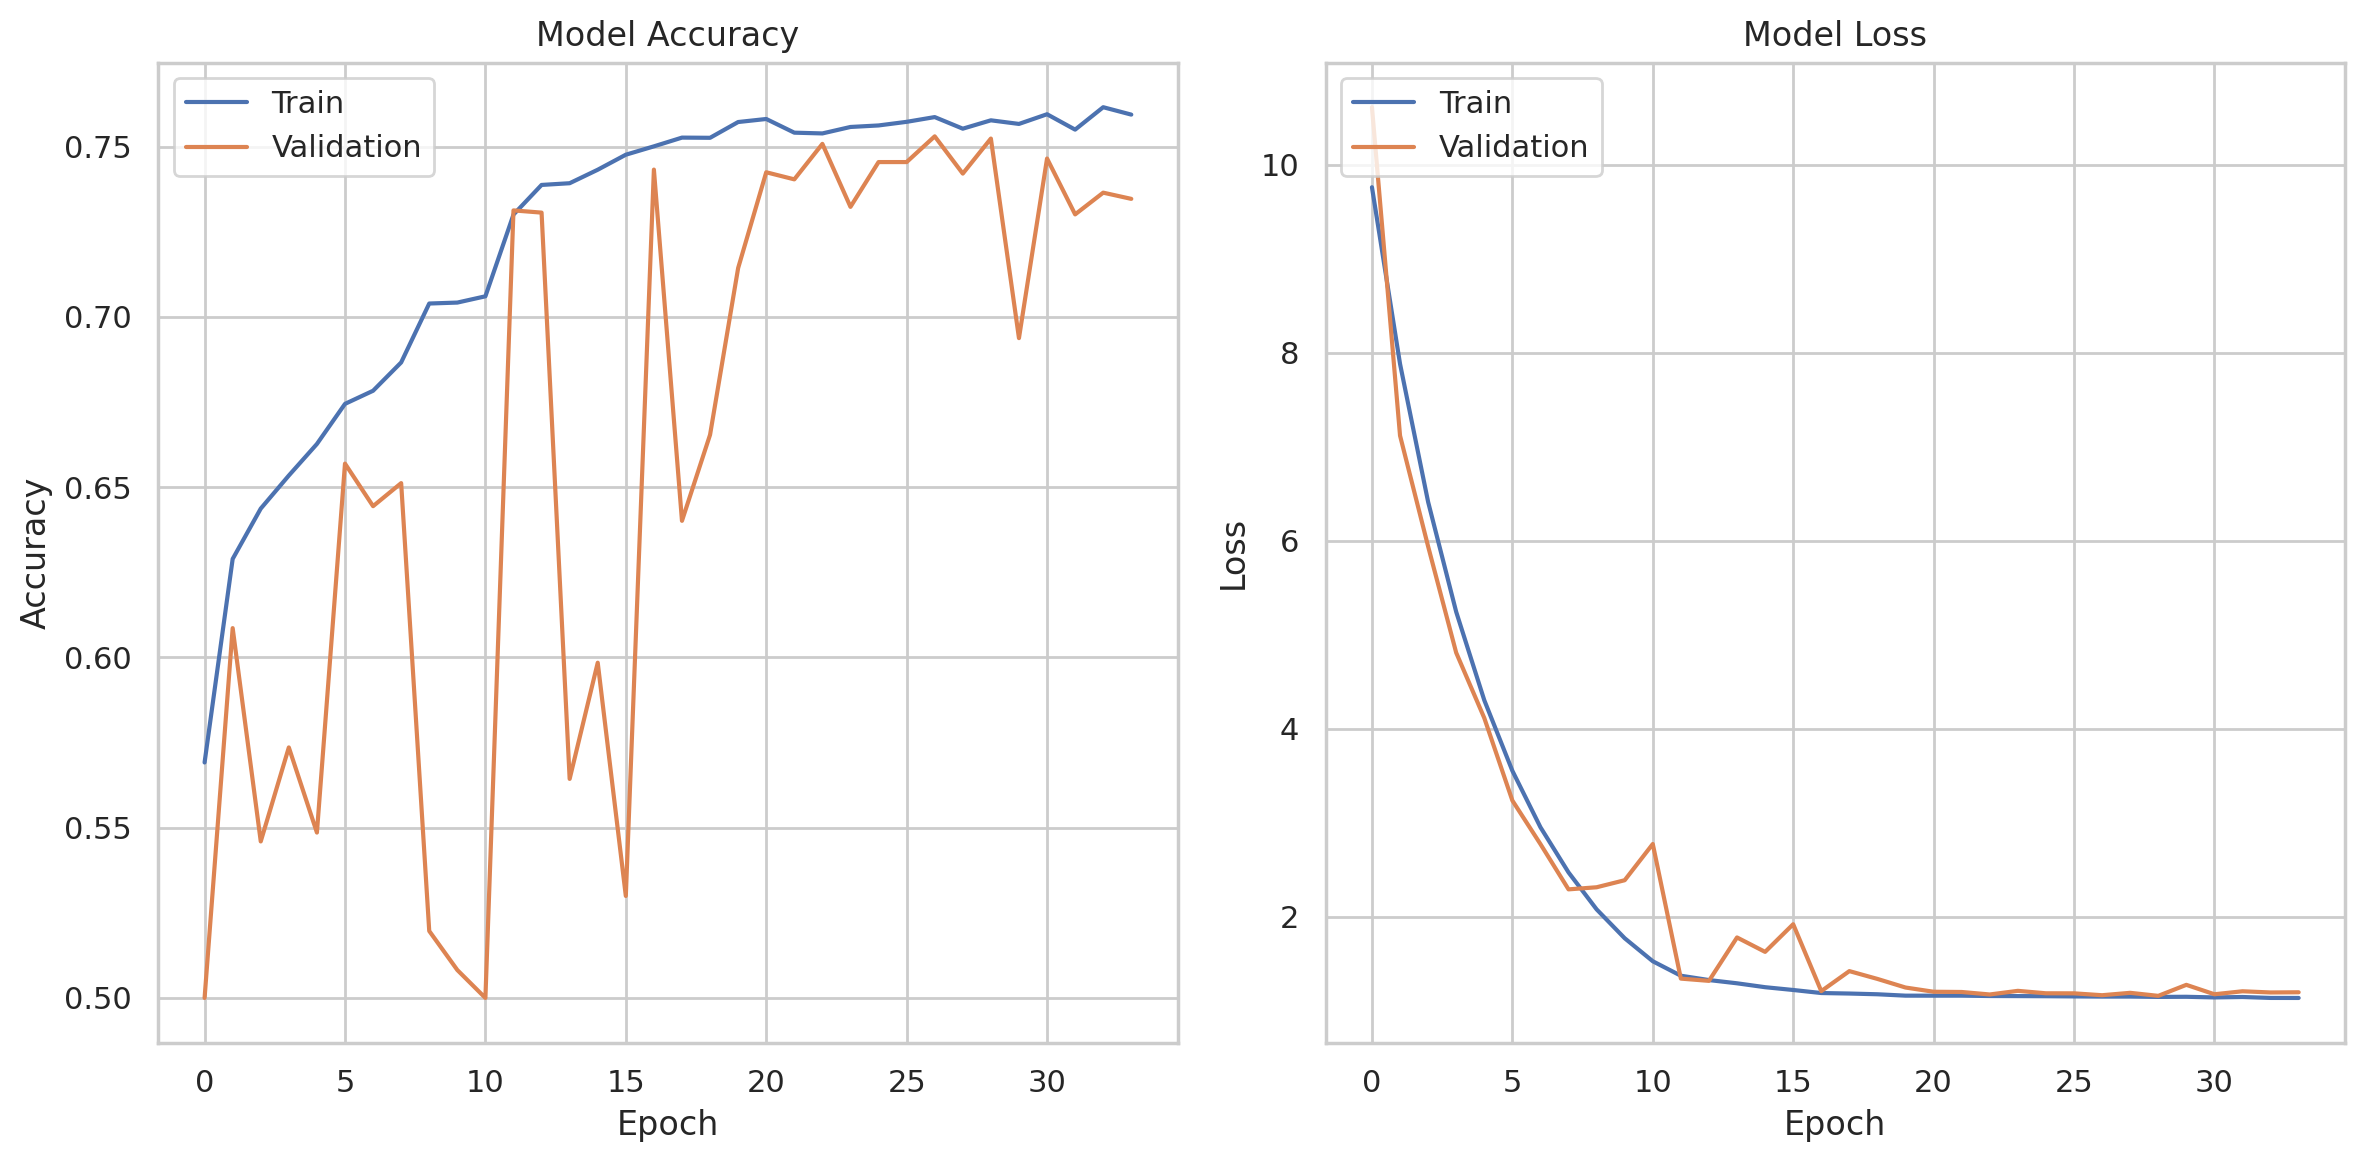

In [30]:
# Visualize training history
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

200/200 [==============================] - 8s 34ms/step - loss: 1.1488 - accuracy: 0.7630

Test Loss: 1.1488
Test Accuracy: 0.7630


200/200 [==============================] - 8s 34ms/step


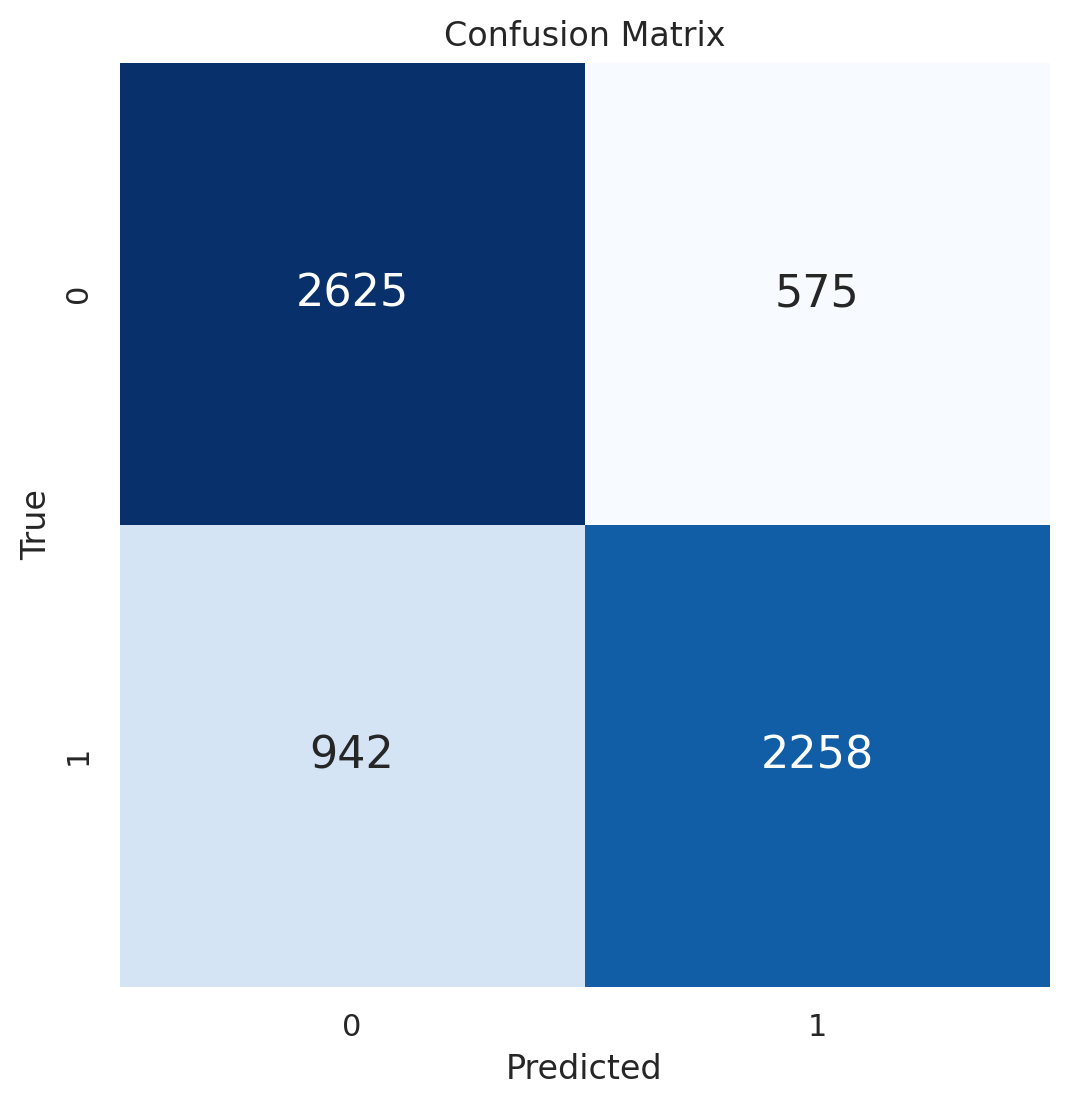

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_mat = confusion_matrix(y_test, y_pred)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3200
           1       0.80      0.71      0.75      3200

    accuracy                           0.76      6400
   macro avg       0.77      0.76      0.76      6400
weighted avg       0.77      0.76      0.76      6400



## 7. Save Final Model

In [19]:
model.save('redeepfake_model.h5')

## 8. Model Reusing Guide

In [20]:
model_path = '/kaggle/working/redeepfake_model.h5'
model = tf.keras.models.load_model(model_path)

In [34]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

In [35]:
test_image_paths = []
for idx,i in enumerate(Test_set.index[125:150]):
    test_image_paths.append(('../input/deepfake-faces/faces_224/'+Test_set.loc[i,'videoname'][:-4]+'.jpg', Test_set.loc[i,'label']))

In [36]:
plt.figure(figsize=(15,15), dpi=300)

for idx, (image_path, label) in enumerate(test_image_paths):
    processed_image = preprocess_image(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(processed_image)
    
    # Threshold for binary classification: 0.5
    predicted_class = "FAKE" if prediction[0, 0] > 0.5 else "REAL"
    
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.xlabel(f'{predicted_class} | {prediction[0, 0]:.2f} | {"T" if predicted_class == label else "F"}')
    
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 23ms/step


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# Function to preprocess the image
def preprocess_image(image_path):
    """
    Load an image from the path and preprocess it for the model.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Adjust the size according to your model input
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

plt.figure(figsize=(15, 15), dpi=300)

# Iterate over a subset of the training set
for idx, i in enumerate(Train_set.index[75:100]):
    plt.subplot(5, 5, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Get the image path and label
    image_path = f"../input/deepfake-faces/faces_224/{Train_set.loc[i, 'videoname'][:-4]}.jpg"
    label = Train_set.loc[i, 'label']
    
    # Preprocess the image and make a prediction
    processed_image = preprocess_image(image_path)
    processed_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(processed_image)
    
    # Threshold for binary classification: 0.33
    predicted_class = "FAKE" if prediction[0, 0] > 0.33 else "REAL"
    
    # Load and display the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    true_class = "FAKE" if label == 'FAKE' else "REAL"
    correctness = "T" if predicted_class == true_class else "F"
    plt.xlabel(f'{predicted_class} | {prediction[0, 0]:.2f} | {correctness}')
    
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 23ms/step
